# Computing the stimulus position using the wheel

In the IBL task a visual stimulus (Gabor patch of size 7°<sup>2</sup>) appears on the left (-35°) or right (+35°) of a screen and the mouse must use a wheel to bring the stimulus to the centre of the screen (0°). If the mouse moves the wheel in the correct direction, the trial is deemed correct and the mouse receives a reward. If however, the mouse moves the wheel 35° in the wrong direction and the stimulus goes off the screen, this is an error trial and the mouse receives a white noise error tone. The screen was positioned 8 cm in front of the animal and centralized relative to the position of eyes to cover ~102 visual degree azimuth. In the case that the mouse moves the stimulus 35° in the wrong direction, the stimulus, therefore is visible for 20° and the rest is off the screen.

For some analyses it may be useful to know the position of the visual stimulus on the screen during a trial. While there is no direct read out of the location of the stimulus on the screen, as the stimulus is coupled to the wheel, we can infer the position using the wheel position. 

Below we walk you through an example of how to compute the continuous stimulus position on the screen for a given trial.

For this anaylsis we need access to information about the wheel radius (3.1 cm) and the wheel gain (visual degrees moved on screen per mm of wheel movement). The wheel gain changes throughout the training period (see our [behavior paper](https://doi.org/10.7554/eLife.63711
) for more information) but for the majority of sessions is set at 4°/mm.

In [1]:
# Turn off logging and disable tqdm this is a hidden cell on docs page
import logging
import os

logger = logging.getLogger('ibllib')
logger.setLevel(logging.CRITICAL)

os.environ["TQDM_DISABLE"] = "1"

## Step 1: Load data

For this analysis we will need to load in the trials and wheel data for a chosen session

In [2]:
from one.api import ONE
one = ONE(base_url='https://openalyx.internationalbrainlab.org')

eid = 'f88d4dd4-ccd7-400e-9035-fa00be3bcfa8'
trials = one.load_object(eid, 'trials')
wheel = one.load_object(eid, 'wheel')

## Step 2: Compute evenly sampled wheel data

The wheel data returned is not evenly sampled, we can sample the data at 1000 Hz using the following function

In [3]:
import brainbox.behavior.wheel as wh
wheel_pos, wheel_times = wh.interpolate_position(wheel.timestamps, wheel.position, freq=1000)

## Step 3: Extract wheel data for a given trial

We now want to find the wheel data in the interval for a given trial

In [4]:
import numpy as np
# Choose trial no. 110 (right contrast = 1) ; or 150 (left)
tr_idx = 110
# Get interval of trial, gives two values, start of trial and end of trial
interval = trials['intervals'][tr_idx]
# Find the index of the wheel timestamps that contain this interval
wheel_idx = np.searchsorted(wheel_times, interval)
# Limit our wheel data to these indexes
wh_pos = wheel_pos[wheel_idx[0]:wheel_idx[1]]
wh_times = wheel_times[wheel_idx[0]:wheel_idx[1]]

## Step 4: Compute the position in mm

The values for the wheel position are given in radians. Since the wheel gain is defined in visual degrees per mm we need to convert the wheel position to mm. We can use the radius of the wheel for this.

In [5]:
# radius of wheel in mm
WHEEL_RADIUS = 3.1 * 10 
# compute circumference of wheel
wh_circ = 2 * np.pi * WHEEL_RADIUS
# compute the mm turned be wheel degree
mm_per_wh_deg = wh_circ / 360
# convert wh_pos from radians to degrees
wh_pos = wh_pos * 180 / np.pi
# convert wh_pos from degrees to mm
wh_pos = wh_pos * mm_per_wh_deg

## Step 5: Compute the wheel displacement from stimOn

To link the visual stimulus movement to the wheel position we need to compute the displacement of the wheel position relative to the time at which the stimulus first appears on the screen.

In [6]:
# Find the index of the wheel timestamps when the stimulus was presented (stimOn_times)
idx_stim = np.searchsorted(wh_times, trials['stimOn_times'][tr_idx])
# Zero the wh_pos to the position at stimOn
wh_pos = wh_pos - wh_pos[idx_stim]

## Step 6: Convert wheel displacement to screen position

Now that we have computed the displacement of the wheel relative to when the stimulus was presented we can use the wheel gain to convert this into degrees of the visual stimlus on the screen.

In [7]:
GAIN_MM_TO_SC_DEG = 4
stim_pos = wh_pos * GAIN_MM_TO_SC_DEG

## Step 7: Fixing screen position linked to events

The stim_pos values that we have above have been computed over the whole trial interval, from trial start to trial end. The stimlus on the screen however is can only move with the wheel between the time at which the stimlus is presented (stimOn_times) and the time at which a choice is made (response_times). After a response is made the visual stimulus then remains in a fixed position until the it disappears from the screen (stimOff_times)

In [8]:
# Find the index of the wheel timestamps when the stimulus was presented (stimOn_times)
idx_stim = np.searchsorted(wh_times, trials['stimOn_times'][tr_idx])
# Find the index of the wheel timestamps when the choice was made (response_times)
idx_res = np.searchsorted(wh_times, trials['response_times'][tr_idx])
# Find the index of the wheel timestamps when the stimulus disappears (stimOff_times)
idx_off = np.searchsorted(wh_times, trials['response_times'][tr_idx])

# Before stimOn no stimulus on screen, so set to nan
stim_pos[0:idx_stim - 1] = np.nan
# Stimulus is in a fixed position between response time and stimOff time
stim_pos[idx_res:idx_off - 1] = stim_pos[idx_res]
# After stimOff no stimulus on screen, so set to nan
stim_pos[idx_off:] = np.nan

The stim_pos values are given relative to stimOn times but the stimulus appears at either -35° or 35° depending on the stimlus side. We therefore need to apply this offset to our stimulus position. We also need to account for the convention that increasing wheel position indicates a counter-clockwise movement and therefore a left-ward (-ve) movement of the stimulus in visual azimuth.

In [9]:
# offset depends on whether stimulus was shown on left or right of screen

ONSET_OFFSET = 35

if np.isnan(trials['contrastLeft'][tr_idx]):
    # The stimulus appeared on the right
    # Values for the screen position will be >0
    offset = ONSET_OFFSET  # The stimulus starts at +35 and goes to --> 0
    stim_pos = -1 * stim_pos + offset
else:
    # The stimulus appeared on the left
    # Values for the screen position will be <0
    offset = -1 * ONSET_OFFSET # The stimulus starts at -35 and goes to --> 0
    stim_pos = -1 * stim_pos + offset

## Step 8: Plotting our results

Finally we can plot our results to see if they make sense

Text(0.5, 0.98, 'ContrastLeft: nan, ContrastRight: 1.0,FeedbackType 1.0')

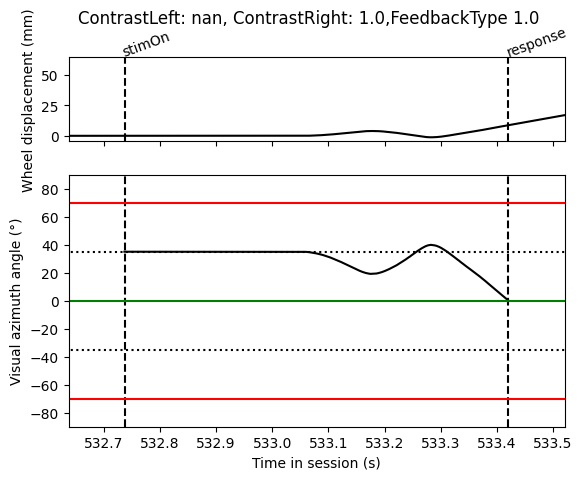

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=[1, 3])

# On top axis plot the wheel displacement
axs[0].plot(wh_times, wh_pos, 'k')
axs[0].vlines([trials['stimOn_times'][tr_idx], trials['response_times'][tr_idx]],
              0, 1, transform=axs[0].get_xaxis_transform(), colors='k', linestyles='dashed')
axs[0].text(trials['stimOn_times'][tr_idx], 1.01, 'stimOn', c='k', rotation=20,
            rotation_mode='anchor', ha='left', transform=axs[0].get_xaxis_transform())
axs[0].text(trials['response_times'][tr_idx], 1.01, 'response', c='k', rotation=20,
            rotation_mode='anchor', ha='left', transform=axs[0].get_xaxis_transform())
axs[0].set_ylabel('Wheel displacement (mm)')


# On bottom axis plot the stimulus position
axs[1].plot(wh_times, stim_pos, 'k')
axs[1].vlines([trials['stimOn_times'][tr_idx], trials['response_times'][tr_idx]],
              0, 1, transform=axs[1].get_xaxis_transform(), colors='k', linestyles='dashed')
axs[1].set_xlim(trials['intervals'][tr_idx])
# black dotted lines indicate starting stimulus position
axs[1].hlines([-35, 35], *axs[1].get_xlim(), colors='k', linestyles='dotted')
# green line indicates threshold for good trial
axs[1].hlines([0], *axs[1].get_xlim(), colors='g', linestyles='solid')
# red lines indicate threshold for incorrect trial
axs[1].hlines([-70, 70], *axs[1].get_xlim(), colors='r', linestyles='solid')

axs[1].set_ylim([-90, 90])
axs[1].set_xlim(trials['stimOn_times'][tr_idx] - 0.1, trials['response_times'][tr_idx] + 0.1)
axs[1].set_ylabel('Visual azimuth angle (°)')
axs[1].set_xlabel('Time in session (s)')
fig.suptitle(f"ContrastLeft: {trials['contrastLeft'][tr_idx]}, ContrastRight: {trials['contrastRight'][tr_idx]},"
                 f"FeedbackType {trials['feedbackType'][tr_idx]}")

